In [2]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr

sns.set()

# 1. Przygotowanie danych
- Wybieramy tylko partię, które uczestniczyły przynajmniej w połowie głosowań

In [3]:
df = pd.read_csv("./data/9/wyniki.csv")
df.head()

,kadencja,posiedzenie,głosowanie,temat,partia,członkowie,głosy,za,przeciw,wstrzymane,brak
0,9,79,1,79. posiedzenie Sejmu Rzeczypospolitej Polskie...,PiS,228,211,0,211,0,17
1,9,79,1,79. posiedzenie Sejmu Rzeczypospolitej Polskie...,KO,126,120,120,0,0,6
2,9,79,1,79. posiedzenie Sejmu Rzeczypospolitej Polskie...,Lewica,43,43,43,0,0,0
3,9,79,1,79. posiedzenie Sejmu Rzeczypospolitej Polskie...,KP,24,19,19,0,0,5
4,9,79,1,79. posiedzenie Sejmu Rzeczypospolitej Polskie...,Konfederacja,9,4,0,2,2,5


In [4]:
_counts = df['partia'].value_counts()
parties = list(_counts[_counts > (_counts.max() / 2)].index)
parties

['PiS',
 'Konfederacja',
 'KO',
 'niez.',
 'Lewica',
 'KP',
 'Polska2050',
 'Kukiz15',
 'PS',
 'Porozumienie']

In [5]:
df = df[df['partia'].isin(parties)]

# 2. Agregacja wyników głosowania
- W tej części wyniki głosowania zostały przedstawione w uproszczonej formie, która ułatwi analizę
- Dla każdego głosowania obliczony został procent posłów, który głosowali "za" w danym głosowaniu
- Głosy oznaczone jako "przeciw", "wstrzymane" lub brak głosu, uznawane są jako głosy oddane nie "za"

In [121]:
_data = []
for (posiedzenie, glosowanie), group in df.groupby(["posiedzenie", "głosowanie"]):
    for _, row in group.iterrows():
        _data.append({
            "posiedzenie": posiedzenie,
            "głosowanie": glosowanie,
            "partia": row["partia"],
            "za": row['za'] / row['członkowie'],
            "przeciw": (1 - row['za'] / row['członkowie'])
        })
df_votes = pd.DataFrame(_data).set_index(['posiedzenie', 'głosowanie'])

In [207]:
df_results = df.groupby(["posiedzenie", "głosowanie"])[["za", "głosy"]].sum()
df_results["przeciwko"] = df_results['głosy'] - df_results['za']
df_results["wygrana"] = df_results['za'] >= df_results["przeciwko"]

## 2.1. Nie po ich myśli
- Ile razy partia rządząca przegrała głosowanie? Jakie były tematy tych głosowań
- W tej analizie rozpatrujemy dwa przypadki:
    - głosowanie, które partia popierała, zostało odrzucone
    - głosowanie, którego partia nie popierała, zostało przyjęte

In [168]:
_df_pis = df_votes.query("partia == 'PiS'")
pis_za = _df_pis[_df_pis['za'] >= 0.5].index
pis_przeciwko = _df_pis[_df_pis['za'] < 0.5].index

### Głosowania, które partia popierała, zostało odrzucone

In [200]:
_df = df_results.loc[pis_za].query('wygrana == False')
przegrane, wszystkie, procent = len(_df), len(pis_za), len(_df) / len(pis_za)

print(f"Partia przegrała {przegrane} głosowań, co stanowiło {procent:.2%} popieranych przez nich głosowań")

Partia przegrała 18 głosowań, co stanowiło 0.48% popieranych przez nich głosowań


In [201]:
_df_votings = df.set_index(['posiedzenie', 'głosowanie']).loc[_df.query("wygrana == False").index]
print("\n\n".join(_df_votings['temat'].unique()))

1. posiedzenie Sejmu Rzeczypospolitej Polskiej: Głosowanie nad ogłoszeniem przerwy w obradach

16. posiedzenie Sejmu Rzeczypospolitej Polskiej w dniu 14 sierpnia 2020 r.: Głosowanie nad zastosowaniem art. 51 pkt 3 regulaminu Sejmu

Pkt 10. porz. dzien. Sprawozdanie Komisji o uchwale Senatu w sprawie ustawy o Funduszu Medycznym: Głosowanie nad odrzuceniem 1. poprawki

Pkt 10. porz. dzien. Sprawozdanie Komisji o uchwale Senatu w sprawie ustawy o Funduszu Medycznym: Głosowanie nad odrzuceniem poprawek 2. i 4.

Pkt 10. porz. dzien. Sprawozdanie Komisji o uchwale Senatu w sprawie ustawy o zmianie ustawy o szczególnych rozwiązaniach związanych z zapobieganiem, przeciwdziałaniem i zwalczaniem COVID-19, innych chorób zakaźnych oraz wywołanych nimi sytuacji kryzysowych oraz niektórych innych ustaw: Głosowanie nad odrzuceniem poprawek 147. i 361.

Pkt 10. porz. dzien. Sprawozdanie Komisji o uchwale Senatu w sprawie ustawy o zmianie ustawy o szczególnych rozwiązaniach związanych z zapobieganiem, 

### Głosowania, którego partia nie popierała, zostało przyjęte

In [202]:
_df = df_results.loc[pis_przeciwko].query('wygrana == True')
przegrane, wszystkie, procent = len(_df), len(pis_za), len(_df) / len(pis_za)

print(f"Partia przegrała {przegrane} głosowań, co stanowiło {procent:.2%} popieranych przez nich głosowań")

Partia przegrała 12 głosowań, co stanowiło 0.32% popieranych przez nich głosowań


In [203]:
_df_votings = df.set_index(['posiedzenie', 'głosowanie']).loc[_df.query("wygrana == True").index]
print("\n\n".join(_df_votings['temat'].unique()))

26. posiedzenie Sejmu Rzeczypospolitej Polskiej w dniach 24 i 25 lutego 2021 r.: Głosowanie nad uzupełnieniem porządku dziennego o punkt w brzmieniu: Informacja Wiceprezesa Rady Ministrów, Ministra Kultury, Dziedzictwa Narodowego i Sportu na temat procedury przyznawania rekompensat w ramach Funduszu Wsparcia Kultury

Rozstrzygnięcie przez Sejm wniosku o uzupełnienie porządku dziennego o punkt: Informacja Ministra Sprawiedliwości, Prokuratora Generalnego na temat działań podejmowanych przez prokuraturę w okresie od dnia 4 marca 2016 r. w celu wydania postanowienia o odmowie wszczęcia śledztwa lub dochodzenia; umorzenia śledztwa lub dochodzenia; cofnięcia aktu oskarżenia; skierowania do sądu wniosku, o którym mowa w art. 5 ustawy z dnia 10 czerwca 2016 r. o zmianie ustawy - Kodeks postępowania karnego, ustawy o zawodach lekarza i lekarza dentysty oraz ustawy o prawach pacjenta i Rzeczniku Praw Pacjenta (Dz.U. z 2016 r. poz. 1070) we wszystkich sprawach, w których podejrzanym lub oskarżon

## 2.3. Najchętniejsi na przerwe

In [213]:
_df = df[df['temat'].str.contains("wniosek o przerwę")]
index = list(_df[['posiedzenie', 'głosowanie']].itertuples(index=False, name=None))
_df_votes = df_votes.loc[index]

In [218]:
df_results.loc[index]['wygrana'].mean()

0.0

Text(0.5, 0, 'Procent partii popieracjącej wniosek')

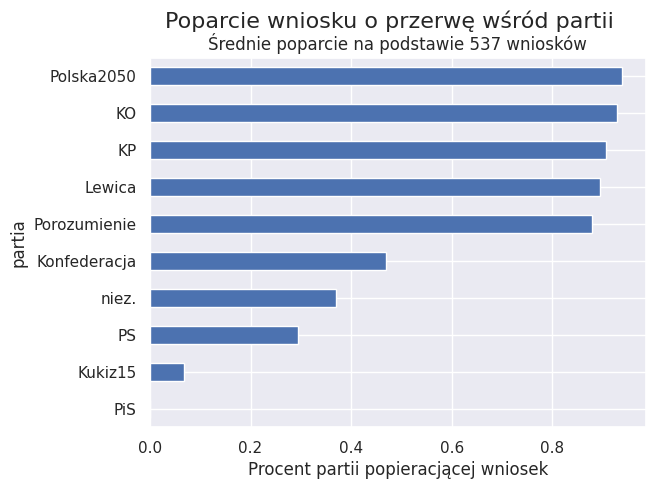

In [220]:
_df_votes.groupby("partia")["za"].mean().sort_values().plot.barh()
plt.suptitle("Poparcie wniosku o przerwę wśród partii", fontsize=16)
plt.title(f"Średnie poparcie na podstawie {len(index)} wniosków")
plt.xlabel("Procent partii popieracjącej wniosek")

## 2.2. Udział w głosowaniach
- Jaki procent posłów partii zazwyczaj bierze udział w głosowaniu

<AxesSubplot: ylabel='partia'>

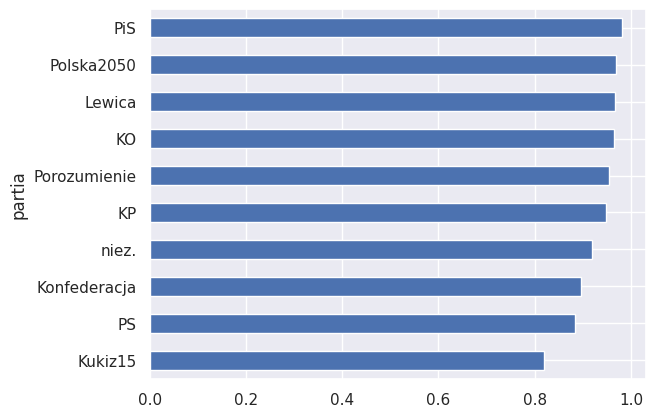

In [44]:
df['procent_głosujących'] = df['głosy'] / df['członkowie'] 
df.groupby('partia')['procent_głosujących'].mean().sort_values().plot.barh()

# 3. Porównywanie partii
- W tej części dane dla każdego głosowania zestawione są w formie tabeli przestawnej
- Każdy wiersz odpowiada jednemu głosowaniu, a kolumna jednej partii
- Wartość w komórce oznacza procent posłów danej partii głosujących "za" w danym głosowaniu

In [45]:
_df = df_votes[df_votes['partia'].isin(parties)]
df_pivot = pd.pivot_table(index=["posiedzenie", "głosowanie"], columns=["partia"], values="za", data=_df)

## 3.1. Czy opozycja jest "totalna"?
- W tej analize sprawdzamy jak często każda z partia głosowała "za" w głosowaniach
- Jest to duże uproszczenie, bo analizowane są wszystkie typy głosowań.

Text(0, 0.5, 'Procent głosujący "za" [%]')

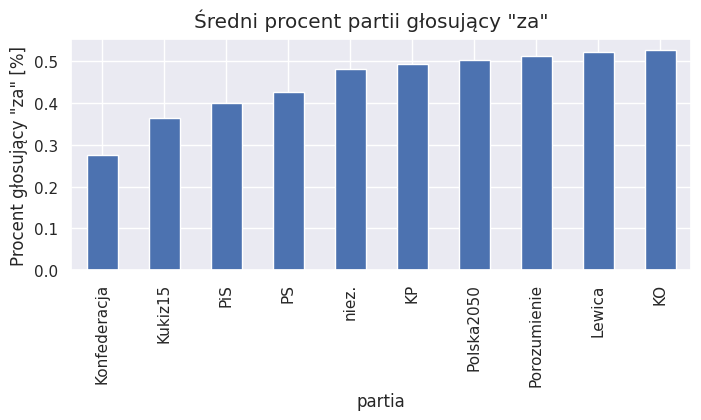

In [49]:
plt.figure(figsize=(8, 3))
plt.suptitle("Średni procent partii głosujący \"za\"")
df_pivot.mean().sort_values().plot.bar()
plt.ylabel("Procent głosujący \"za\" [%]")

Text(0, 0.5, 'Głosy "przeciw" [%]')

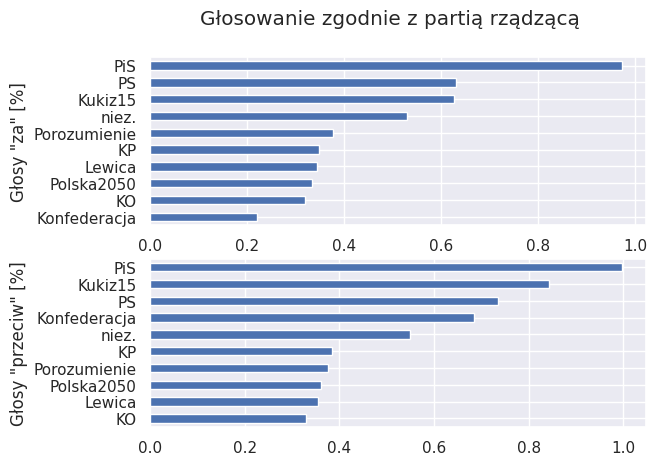

In [231]:
_, axes = plt.subplots(2, 1)
plt.suptitle("Głosowanie zgodnie z partią rządzącą")


_df = df_pivot[df_pivot['PiS'] >= 0.5]
_df.mean().sort_values().plot.barh(ax=axes[0])

_df = df_pivot[df_pivot['PiS'] < 0.5]
(1-_df).mean().sort_values().plot.barh(ax=axes[1])


axes[0].set_ylabel("Głosy \"za\" [%]")
axes[1].set_ylabel("Głosy \"przeciw\" [%]")

## 3.3. Kto głosuje podobnie
- W tej części przebana została korelacja pomiędzy głosami różnych partii
- Dla każdego głosowania porównywany jest procent członków partii głosujących "za"

In [223]:
_data = []
for party in parties:
    for other in parties:
        _df = df_pivot[(df_pivot[party].notnull()) & (df_pivot[other].notnull())]
        _data.append({
            "party1": party,
            "party2": other,
            "MAE": (_df[other] - _df[party]).abs().mean(),
            "spearman": spearmanr(_df[party], _df[other]).correlation,
            "pearson": pearsonr(_df[party], _df[other])[0],
        })

In [224]:
df_corr = pd.pivot(
    index="party1",
    columns="party2",
    values=["MAE", "spearman", "pearson"],
    data=pd.DataFrame(_data)
)

<AxesSubplot: xlabel='party2', ylabel='party1'>

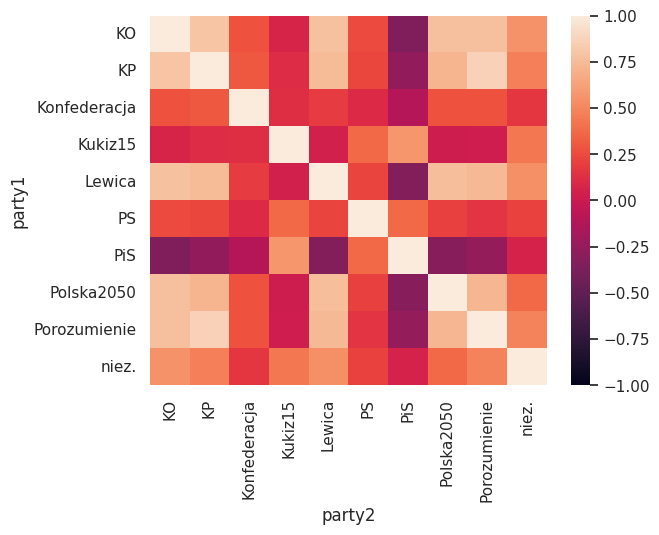

In [225]:
sns.heatmap(df_corr['spearman'], vmin=-1, vmax=1)

# 4. Analiza zmiany w czasie (WIP)

## 4.1. Kto najbardziej zmieniał zdanie

Text(0, 0.5, 'Średnia różnica')

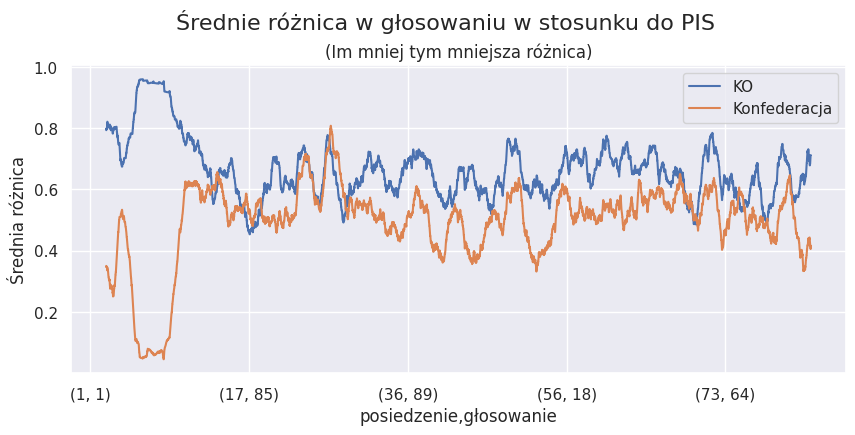

In [227]:
plt.subplots(figsize=(10, 4))
(df_pivot["KO"] - df_pivot["PiS"]).abs().dropna().rolling(200).mean().plot(label="KO")
(df_pivot["Konfederacja"] - df_pivot["PiS"]).abs().dropna().rolling(200).mean().plot(label="Konfederacja")
plt.legend()
plt.suptitle("Średnie różnica w głosowaniu w stosunku do PIS", fontsize=16, y=1.02)
plt.title("(Im mniej tym mniejsza różnica)")
plt.ylabel("Średnia różnica")